In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [19]:
import numpy as np
import pandas as pd

In [20]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [23]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [24]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [25]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)



In [27]:
#Get the column names by printing out the dictionary values of the first row of Measurements table
first_row_m = session.query(Measurement).first()
print(first_row_m.__dict__)


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000000000E3103C8>, 'tobs': 65.0, 'date': '2010-01-01', 'id': 1, 'prcp': 0.08, 'station': 'USC00519397'}


In [28]:
#Get the column names by printing out the dictionary values of the first row of Station table
first_row_s = session.query(Station).first()
print(first_row_s.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000000000E179B48>, 'station': 'USC00519397', 'latitude': 21.2716, 'elevation': 3.0, 'longitude': -157.8168, 'id': 1, 'name': 'WAIKIKI 717.2, HI US'}


# Exploratory Climate Analysis

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Get the latest date in the data
first_row_m = session.query(Measurement).order_by(sqlalchemy.desc(Measurement.date)).first()
print(first_row_m.date)

2017-08-23


In [32]:
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
year_data = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date >= "2016-08-23")
print(year_data.count())

# Save the query results as a Pandas DataFrame
year_data_df = pd.DataFrame()
year_data_df = pd.DataFrame(year_data)

#Drop any missing columns
year_data_df = year_data_df.dropna()

#Set index to date columns
year_data_df.set_index('date',inplace=True)
year_data_df.index = pd.to_datetime(year_data_df.index)

# Sort the dataframe by date
year_data_df = year_data_df.sort_values(by="date")

#Print values to see if everything sorted
print(year_data_df.head(10))

2230
            prcp
date            
2016-08-23  0.00
2016-08-23  0.02
2016-08-23  0.05
2016-08-23  0.70
2016-08-23  0.15
2016-08-23  1.79
2016-08-24  1.22
2016-08-24  0.08
2016-08-24  2.15
2016-08-24  2.15


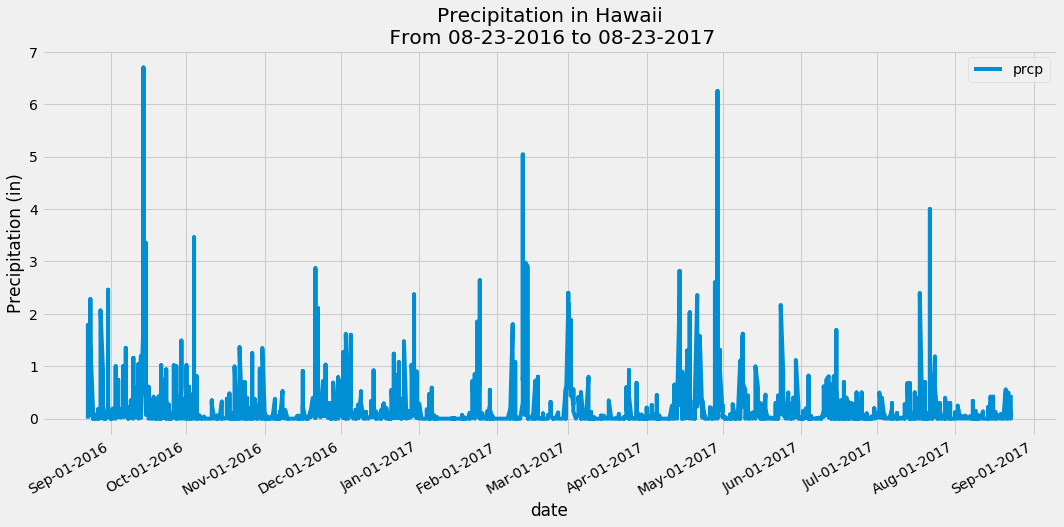

In [33]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(15,7))
#Plots a line graph, uses the x_compat parameter to clean the tick marks on the plot
year_data_df.plot(ax=ax, x_compat=True)

#Uses matplotlib dates library functions to further format data
#Plots first instances of new month, formats it according to Mon-DD-YYYY
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d-%Y'))

plt.ylabel("Precipitation (in)")
plt.tight_layout()
plt.title('Precipitation in Hawaii\n From 08-23-2016 to 08-23-2017')
plt.savefig('Hawaii_Prcp.png')
plt.show()

In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_data_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## The data set has a count of 2021 entries. The mean precipitation level is .177 inches. Standard deviation is .461. Minimum value is 0. 1st quartile of data is 0. The median is .02. 3rd quartile of data is .13. Maximum value of the data is 6.7. 
## The summary statistics describe that at least 500 (roughly 25% of the values) recorded precipitation levels across all stations were at 0.

In [35]:
# Design a query to show how many stations are available in this dataset?

#Uses distinct function in sqlalchemy to find the count of unique stations
station_count = session.query(Measurement.station).distinct().count()
print(station_count)

9


## There are 9 stations available in this dataset

In [36]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#Queries both tables and joins them using a filter of like-columns. Gets aggregate data using func to find the count of each station after they are grouped by the station number. Uses sqlalchemy desc function to display the count in descending order
active_stations = session.query(Measurement.station, Station.name, func.count(Measurement.station)).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(sqlalchemy.desc(func.count(Measurement.station))).all()
print(active_stations)

[('USC00519281', 'WAIHEE 837.5, HI US', 2772), ('USC00519397', 'WAIKIKI 717.2, HI US', 2724), ('USC00513117', 'KANEOHE 838.1, HI US', 2709), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979), ('USC00517948', 'PEARL CITY, HI US', 1372), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]


## Station USC00519281, Waihee 837.5 has the highest count of activity at 2772. Station USC00518838, Upper Wahiawa 874.3 has the lowest activity count at 511

In [37]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#Filters according to the station ID with the most activity. Uses func to find the aggregate data for that station. Also joins the tables on the same column (station ID) to print the name of the station
temp_analysis = session.query(Measurement.station, Station.name, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == Station.station).filter(Measurement.station == "USC00519281").all()
print(temp_analysis)

[('USC00519281', 'WAIHEE 837.5, HI US', 54.0, 85.0, 71.66378066378067)]


## Station USC00519281 has a low temp of 54.0, a high temp of 85.0, and an average temp of 71.66

In [38]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#
temp_data = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == "USC00519281").filter(Measurement.date >= "2016-08-23").all()

# print(temp_data) displays a list of the temperature observations after August 23, 2016 for station USC00519281

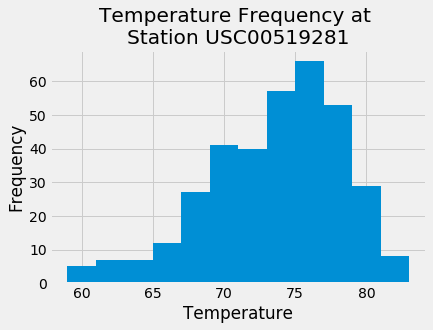

In [39]:
#Store the query data into a Dataframe
temp_data_df = pd.DataFrame(temp_data)

#Creates a histogram using the temperature data, separated into 12 bins
temp_data_df.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Frequency at \nStation USC00519281")
plt.savefig('Temp_Frequency.png')
plt.show()